# Comprehensive Validation Workflow: Putting It All Together

This notebook demonstrates a **comprehensive validation workflow** that combines all validation techniques to thoroughly test a model recommendation before deployment.

Understanding comprehensive validation is essential because:
- **No single technique catches everything** - you need multiple validation approaches
- **Validation prevents failures** - catching problems before deployment saves time and money
- **Systematic validation builds confidence** - you know the recommendation has been thoroughly tested
- **This is how professionals validate models** - comprehensive validation is standard practice


## Key Concepts

**Comprehensive Validation** combines multiple techniques:
- **Sensitivity Analysis**: Tests how recommendations change when inputs change
- **What-If Analysis**: Explores multiple complete scenarios
- **Extreme-Value Testing**: Tests model behavior at boundaries
- **Assumption Stress Testing**: Systematically breaks assumptions
- **Sanity Checks**: Applies business judgment to evaluate recommendations

**Why It Matters**:
- **Each technique catches different problems** - together they provide comprehensive coverage
- **Systematic validation prevents failures** - you catch problems before deployment
- **Validation builds confidence** - you know the recommendation has been thoroughly tested
- **It's a necessary step** - never deploy without validation

**Critical insight**: Comprehensive validation is like quality control - you check the recommendation thoroughly before using it, just like you check a product before selling it.


## Scenario: Production Planning Decision

You manage a factory and receive a model recommendation for next month's production plan. The model recommends:
- Produce 1,200 units of Product A
- Produce 800 units of Product B

**The Challenge**: Before implementing this recommendation, you need to validate it comprehensively using all validation techniques.

**The Question**: Does this recommendation pass comprehensive validation? Is it safe to deploy?

**Decision**: Whether to implement the production plan

**Validation techniques to apply**: All five techniques systematically


## Step 1: Install Required Packages (Colab)

If you're running this notebook in Google Colab, you need to install the `pulp` package first. This cell can be skipped if running locally and the package is already installed.


In [11]:
# Install pulp package (required for optimization)
# This is needed in Google Colab; can be skipped if already installed locally
%pip install pulp -q



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries

We'll use pandas for data manipulation and analysis, numpy for numerical calculations, matplotlib for visualizations, and pulp for solving the optimization model that generates our production recommendations.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, value, PULP_CBC_CMD


## Step 3: Set Up the Model and Base Recommendation

In this step, we create the production planning optimization model and obtain the base recommendation that we'll validate. This recommendation serves as our starting point for comprehensive validation.

**What the model does**:
- **Objective**: Maximize total profit from producing Products A and B
- **Constraints**:
  - Total production cannot exceed factory capacity
  - Total labor hours used cannot exceed available labor hours
  - Production of each product cannot exceed its demand forecast
- **Decision variables**: How many units to produce of Product A and Product B

**Base recommendation**:
- The model recommends producing 1,200 units of Product A and 800 units of Product B
- Expected profit: $92,000

**Why this matters**: Before implementing this recommendation, we need to validate it thoroughly. The model's recommendation is based on specific assumptions (demand forecasts, profit margins, capacity, labor), and if any of these are wrong, the recommendation could be suboptimal or even harmful.


In [13]:
def solve_production_model(demand_A, demand_B, profit_A, profit_B, capacity, labor_hours, labor_per_A, labor_per_B):
    """Solve production planning model"""
    model = LpProblem("Production_Planning", LpMaximize)
    produce_A = LpVariable("produce_A", lowBound=0, cat='Integer')
    produce_B = LpVariable("produce_B", lowBound=0, cat='Integer')
    model += profit_A * produce_A + profit_B * produce_B, "Total_Profit"
    model += produce_A + produce_B <= capacity, "Capacity_Limit"
    model += labor_per_A * produce_A + labor_per_B * produce_B <= labor_hours, "Labor_Limit"
    model += produce_A <= demand_A, "Demand_A_Limit"
    model += produce_B <= demand_B, "Demand_B_Limit"
    model.solve(PULP_CBC_CMD(msg=0))
    return (value(produce_A), value(produce_B), value(model.objective))

# Base inputs
base_demand_A = 1200
base_demand_B = 800
base_profit_A = 50
base_profit_B = 40
base_capacity = 2000
base_labor_hours = 1500
base_labor_per_A = 0.5
base_labor_per_B = 0.8

# Get base recommendation
base_A, base_B, base_profit = solve_production_model(
    base_demand_A, base_demand_B, base_profit_A, base_profit_B,
    base_capacity, base_labor_hours, base_labor_per_A, base_labor_per_B
)

print("BASE MODEL RECOMMENDATION:")
print("=" * 80)
print(f"  Produce {base_A:.0f} units of Product A")
print(f"  Produce {base_B:.0f} units of Product B")
print(f"  Expected Profit: ${base_profit:,.0f}")
print(f"\nNow we'll validate this recommendation using all validation techniques...")


BASE MODEL RECOMMENDATION:
  Produce 1200 units of Product A
  Produce 800 units of Product B
  Expected Profit: $92,000

Now we'll validate this recommendation using all validation techniques...


## Step 4: Validation Technique 1 - Sensitivity Analysis

Sensitivity analysis tests how much the recommendation changes when inputs change. This helps us understand how stable the recommendation is and whether small errors in inputs could lead to large errors in the recommendation.

**What we're doing**:
- We vary one input at a time (in this case, Demand A) across a range
- We observe how the production recommendation changes
- We calculate sensitivity metrics (maximum change, sensitivity ratio)
- We classify the sensitivity level (low, moderate, or high risk)

**Why this matters**:
- If the recommendation is highly sensitive, small errors in demand forecasts could lead to large production errors
- High sensitivity means we need very accurate input estimates
- Low sensitivity means the recommendation is robust to input errors
- This helps us understand the risk level of implementing the recommendation

**What to look for**:
- **High sensitivity** (>0.5 ratio) = HIGH RISK - recommendation changes significantly with input changes
- **Moderate sensitivity** (0.2-0.5 ratio) = MODERATE RISK - recommendation changes moderately
- **Low sensitivity** (<0.2 ratio) = LOW RISK - recommendation is relatively stable


In [14]:
# Sensitivity analysis: Test demand A
demand_A_values = np.arange(1100, 1301, 50)
sensitivity_results = []

for d_A in demand_A_values:
    prod_A, prod_B, profit = solve_production_model(
        d_A, base_demand_B, base_profit_A, base_profit_B,
        base_capacity, base_labor_hours, base_labor_per_A, base_labor_per_B
    )
    sensitivity_results.append({
        'Demand_A': d_A,
        'Produce_A': prod_A,
        'Produce_B': prod_B,
        'Change_A': prod_A - base_A
    })

sens_df = pd.DataFrame(sensitivity_results)
max_change_A = sens_df['Change_A'].abs().max()
sensitivity_ratio = abs(sens_df[sens_df['Demand_A'] == base_demand_A + 100]['Change_A'].values[0] / 100) if len(sens_df[sens_df['Demand_A'] == base_demand_A + 100]) > 0 else 0

print("VALIDATION 1: SENSITIVITY ANALYSIS")
print("=" * 80)
print(f"  Tested: Demand A from {demand_A_values.min()} to {demand_A_values.max()}")
print(f"  Maximum change in recommendation: {max_change_A:.0f} units")
print(f"  Sensitivity ratio: {sensitivity_ratio:.2f}")
if sensitivity_ratio > 0.5:
    print(f"  ⚠️  HIGHLY SENSITIVE - Recommendation changes significantly")
    sensitivity_status = "HIGH RISK"
elif sensitivity_ratio > 0.2:
    print(f"  ⚠️  MODERATELY SENSITIVE - Recommendation changes moderately")
    sensitivity_status = "MODERATE RISK"
else:
    print(f"  ✓  LOW SENSITIVITY - Recommendation is relatively stable")
    sensitivity_status = "LOW RISK"


VALIDATION 1: SENSITIVITY ANALYSIS
  Tested: Demand A from 1100 to 1300
  Maximum change in recommendation: 100 units
  Sensitivity ratio: 1.00
  ⚠️  HIGHLY SENSITIVE - Recommendation changes significantly


## Step 5: Validation Technique 2 - What-If Analysis

What-if analysis explores multiple complete scenarios to see how the recommendation performs across different possible futures. Unlike sensitivity analysis (which changes one input), what-if analysis changes multiple inputs together to create realistic scenarios.

**What we're doing**:
- We define multiple scenarios (optimistic, realistic, pessimistic)
- Each scenario has different values for multiple inputs (demand A and demand B)
- We solve the model for each scenario and compare results
- We calculate the profit range across scenarios

**Why this matters**:
- Real-world conditions rarely match base forecasts exactly
- Multiple inputs often change together (e.g., high demand for both products)
- What-if analysis shows how the recommendation performs in different futures
- Large profit ranges indicate high risk - the recommendation might not work well if conditions differ

**What to look for**:
- **High variability** (>30% of base profit) = HIGH RISK - recommendation varies significantly
- **Moderate variability** (<30% of base profit) = MODERATE RISK - recommendation is relatively stable
- This helps us understand the range of possible outcomes


In [15]:
# What-if analysis: Test multiple scenarios
scenarios = {
    'Optimistic': {'demand_A': 1400, 'demand_B': 900},
    'Realistic': {'demand_A': 1200, 'demand_B': 800},
    'Pessimistic': {'demand_A': 1000, 'demand_B': 700}
}

whatif_results = {}
for scenario_name, scenario_data in scenarios.items():
    prod_A, prod_B, profit = solve_production_model(
        scenario_data['demand_A'], scenario_data['demand_B'],
        base_profit_A, base_profit_B, base_capacity, base_labor_hours,
        base_labor_per_A, base_labor_per_B
    )
    whatif_results[scenario_name] = {
        'Produce_A': prod_A,
        'Produce_B': prod_B,
        'Profit': profit
    }

whatif_df = pd.DataFrame(whatif_results).T
profit_range = whatif_df['Profit'].max() - whatif_df['Profit'].min()

print("VALIDATION 2: WHAT-IF ANALYSIS")
print("=" * 80)
display(whatif_df.round(0))
print(f"\n  Profit range across scenarios: ${profit_range:,.0f}")
if profit_range > base_profit * 0.3:
    print(f"  ⚠️  HIGH VARIABILITY - Recommendation varies significantly across scenarios")
    whatif_status = "HIGH RISK"
else:
    print(f"  ✓  MODERATE VARIABILITY - Recommendation is relatively stable")
    whatif_status = "MODERATE RISK"


VALIDATION 2: WHAT-IF ANALYSIS


,Produce_A,Produce_B,Profit
Optimistic,1400.0,600.0,94000.0
Realistic,1200.0,800.0,92000.0
Pessimistic,1000.0,700.0,78000.0



  Profit range across scenarios: $16,000
  ✓  MODERATE VARIABILITY - Recommendation is relatively stable


## Step 6: Validation Technique 3 - Extreme-Value Testing

Extreme-value testing pushes inputs to their minimum and maximum possible values to see how the model behaves at boundaries. This helps identify where the model breaks or produces invalid results.

**What we're doing**:
- We test extreme scenarios: minimum demand, maximum demand, zero demand
- We verify that the model produces valid recommendations even at extremes
- We check if the model handles edge cases correctly

**Why this matters**:
- Extreme conditions do happen (even if rare), and we need to be prepared
- Models often break at boundaries - they work fine for normal conditions but fail at extremes
- Extreme-value testing finds the model's limits
- It helps us know when to trust the model and when to use alternatives

**What to look for**:
- All tests pass = Model handles extremes well
- Some tests fail = Model has limits that need to be documented
- This helps us understand the model's valid operating range


In [16]:
# Extreme-value testing
extreme_tests = [
    {'name': 'Minimum Demand', 'demand_A': 500, 'demand_B': 400},
    {'name': 'Maximum Demand', 'demand_A': 1800, 'demand_B': 1200},
    {'name': 'Zero Demand A', 'demand_A': 0, 'demand_B': base_demand_B}
]

extreme_results = []
for test in extreme_tests:
    try:
        prod_A, prod_B, profit = solve_production_model(
            test['demand_A'], test['demand_B'],
            base_profit_A, base_profit_B, base_capacity, base_labor_hours,
            base_labor_per_A, base_labor_per_B
        )
        extreme_results.append({
            'Test': test['name'],
            'Produce_A': prod_A,
            'Produce_B': prod_B,
            'Valid': True
        })
    except:
        extreme_results.append({
            'Test': test['name'],
            'Produce_A': None,
            'Produce_B': None,
            'Valid': False
        })

extreme_df = pd.DataFrame(extreme_results)
all_valid = extreme_df['Valid'].all()

print("VALIDATION 3: EXTREME-VALUE TESTING")
print("=" * 80)
display(extreme_df)
if all_valid:
    print(f"  ✓  Model handles extremes - All tests passed")
    extreme_status = "PASS"
else:
    print(f"  ⚠️  Model breaks at extremes - Some tests failed")
    extreme_status = "FAIL"


VALIDATION 3: EXTREME-VALUE TESTING


,Test,Produce_A,Produce_B,Valid
0,Minimum Demand,500.0,400.0,True
1,Maximum Demand,1800.0,200.0,True
2,Zero Demand A,0.0,800.0,True


  ✓  Model handles extremes - All tests passed


## Step 7: Validation Technique 4 - Assumption Stress Testing

Assumption stress testing systematically breaks each key assumption to see how sensitive the recommendation is to each one. This helps identify which assumptions are critical and need accurate estimates.

**What we're doing**:
- We take each key assumption (demand A, demand B, capacity) and make it wrong
- We observe how the recommendation changes when each assumption is broken
- We calculate the impact of each assumption error
- We classify assumptions as critical (high impact) or less critical (low impact)

**Why this matters**:
- Assumptions are often wrong - stress testing prepares us for when they are
- Critical assumptions need accurate estimates - invest effort where it matters
- Less critical assumptions can use rough estimates - don't waste effort
- This helps us prioritize our data collection and analysis efforts

**What to look for**:
- **High impact** (>100 units change) = Critical assumption - needs accurate estimate
- **Low impact** (<50 units change) = Less critical assumption - rough estimate may be sufficient
- This helps us understand which inputs we need to verify most carefully


In [17]:
# Assumption stress testing
stress_tests = [
    {'assumption': 'Demand A', 'base': base_demand_A, 'test': base_demand_A * 0.8},
    {'assumption': 'Demand B', 'base': base_demand_B, 'test': base_demand_B * 0.8},
    {'assumption': 'Capacity', 'base': base_capacity, 'test': base_capacity * 0.9}
]

stress_results = []
for test in stress_tests:
    if test['assumption'] == 'Demand A':
        prod_A, prod_B, profit = solve_production_model(
            test['test'], base_demand_B, base_profit_A, base_profit_B,
            base_capacity, base_labor_hours, base_labor_per_A, base_labor_per_B
        )
    elif test['assumption'] == 'Demand B':
        prod_A, prod_B, profit = solve_production_model(
            base_demand_A, test['test'], base_profit_A, base_profit_B,
            base_capacity, base_labor_hours, base_labor_per_A, base_labor_per_B
        )
    else:  # Capacity
        prod_A, prod_B, profit = solve_production_model(
            base_demand_A, base_demand_B, base_profit_A, base_profit_B,
            test['test'], base_labor_hours, base_labor_per_A, base_labor_per_B
        )
    
    change_A = abs(prod_A - base_A)
    stress_results.append({
        'Assumption': test['assumption'],
        'Change %': ((test['test'] - test['base']) / test['base'] * 100),
        'Change in Recommendation': change_A,
        'Impact': 'High' if change_A > 100 else 'Moderate' if change_A > 50 else 'Low'
    })

stress_df = pd.DataFrame(stress_results)
max_impact = stress_df['Change in Recommendation'].max()

print("VALIDATION 4: ASSUMPTION STRESS TESTING")
print("=" * 80)
display(stress_df.round(0))
print(f"\n  Maximum impact: {max_impact:.0f} units change")
if max_impact > 100:
    print(f"  ⚠️  HIGH IMPACT - Critical assumptions identified")
    stress_status = "HIGH RISK"
else:
    print(f"  ✓  MODERATE IMPACT - Assumptions are manageable")
    stress_status = "MODERATE RISK"


VALIDATION 4: ASSUMPTION STRESS TESTING


,Assumption,Change %,Change in Recommendation,Impact
0,Demand A,-20.0,240.0,High
1,Demand B,-20.0,0.0,Low
2,Capacity,-10.0,0.0,Low



  Maximum impact: 240 units change
  ⚠️  HIGH IMPACT - Critical assumptions identified


## Step 8: Validation Technique 5 - Sanity Checks

Sanity checks apply business judgment to evaluate whether the recommendation makes operational sense. Even if all other validation techniques pass, sanity checks catch recommendations that are mathematically correct but practically absurd.

**What we're checking**:
- **Operational feasibility**: Is production physically possible? Are quantities non-negative?
- **Capacity constraints**: Does production exceed capacity limits?
- **Demand requirements**: Does production meet minimum demand requirements?
- **Business reasonableness**: Is the profit reasonable? Is labor feasible?

**Why this matters**:
- Models can produce mathematically optimal solutions that are operationally impossible
- Business judgment catches what math misses - practical constraints, regulations, stakeholder acceptance
- Sanity checks are quick but powerful - they catch obvious problems immediately
- They're the last line of defense before implementation

**What to look for**:
- All checks pass = Recommendation makes operational sense
- Any check fails = Recommendation should be rejected or investigated
- This ensures the recommendation is not just mathematically optimal, but also practically feasible


In [18]:
# Sanity checks
sanity_checks = [
    {'Check': 'Is production possible?', 'Pass': base_A + base_B <= base_capacity, 'Issue': 'Exceeds capacity'},
    {'Check': 'Are quantities non-negative?', 'Pass': base_A >= 0 and base_B >= 0, 'Issue': 'Negative quantities'},
    {'Check': 'Does it meet minimum demand?', 'Pass': base_A <= base_demand_A * 1.2, 'Issue': 'Produces way more than demand'},
    {'Check': 'Is profit reasonable?', 'Pass': base_profit > 0, 'Issue': 'Negative profit'},
    {'Check': 'Is labor feasible?', 'Pass': base_labor_per_A * base_A + base_labor_per_B * base_B <= base_labor_hours, 'Issue': 'Exceeds labor hours'}
]

sanity_results = []
all_pass = True
for check in sanity_checks:
    sanity_results.append({
        'Check': check['Check'],
        'Passes': check['Pass'],
        'Status': '✓ PASS' if check['Pass'] else f'✗ FAIL: {check["Issue"]}'
    })
    if not check['Pass']:
        all_pass = False

sanity_df = pd.DataFrame(sanity_results)

print("VALIDATION 5: SANITY CHECKS")
print("=" * 80)
display(sanity_df)
if all_pass:
    print(f"  ✓  All sanity checks passed")
    sanity_status = "PASS"
else:
    print(f"  ⚠️  Some sanity checks failed - Recommendation has issues")
    sanity_status = "FAIL"


VALIDATION 5: SANITY CHECKS


,Check,Passes,Status
0,Is production possible?,True,✓ PASS
1,Are quantities non-negative?,True,✓ PASS
2,Does it meet minimum demand?,True,✓ PASS
3,Is profit reasonable?,True,✓ PASS
4,Is labor feasible?,True,✓ PASS


  ✓  All sanity checks passed


## Step 9: Validation Summary and Decision

This step synthesizes all validation results into a comprehensive summary and provides a framework for making the final decision about whether to implement the recommendation.

**What we're doing**:
- Compiling results from all five validation techniques
- Creating a summary table showing the status of each validation
- Identifying key findings from each technique
- Making a final recommendation based on the overall validation results

**Decision framework**:
- **All validations pass or low risk** = Safe to implement
- **Some moderate risks** = Implement with caution, monitor closely
- **High risks or failures** = Do not implement, investigate and fix issues first

**Why this matters**:
- A single validation technique might miss problems that others catch
- Comprehensive validation provides confidence that the recommendation has been thoroughly tested
- The summary helps communicate validation results to stakeholders
- It provides a clear framework for decision-making

**What to look for**:
- Overall risk level across all validations
- Which validations passed and which raised concerns
- Whether the recommendation is safe to implement or needs revision


In [19]:
# Compile validation summary
validation_summary = pd.DataFrame({
    'Validation Technique': [
        'Sensitivity Analysis',
        'What-If Analysis',
        'Extreme-Value Testing',
        'Assumption Stress Testing',
        'Sanity Checks'
    ],
    'Status': [
        sensitivity_status,
        whatif_status,
        extreme_status,
        stress_status,
        sanity_status
    ],
    'Key Finding': [
        f'Sensitivity ratio: {sensitivity_ratio:.2f}',
        f'Profit range: ${profit_range:,.0f}',
        f'Extreme tests: {"All passed" if all_valid else "Some failed"}',
        f'Max impact: {max_impact:.0f} units',
        f'Sanity checks: {"All passed" if all_pass else "Some failed"}'
    ]
})

print("COMPREHENSIVE VALIDATION SUMMARY:")
print("=" * 80)
display(validation_summary)

# Determine overall recommendation
risk_count = sum([1 for s in validation_summary['Status'] if 'RISK' in s or s == 'FAIL'])
if risk_count == 0:
    overall_status = "APPROVED - Safe to deploy"
    recommendation = "✓ IMPLEMENT - All validations passed"
elif risk_count <= 2:
    overall_status = "CONDITIONAL - Deploy with caution"
    recommendation = "⚠️  IMPLEMENT WITH MODIFICATIONS - Address identified risks"
else:
    overall_status = "REJECTED - Do not deploy"
    recommendation = "✗ DO NOT IMPLEMENT - Too many validation failures"

print(f"\nOVERALL VALIDATION RESULT:")
print("=" * 80)
print(f"  Status: {overall_status}")
print(f"  Risk Count: {risk_count} out of 5 validations")
print(f"  Recommendation: {recommendation}")

if risk_count > 0:
    print(f"\n  Issues to address:")
    for idx, row in validation_summary.iterrows():
        if 'RISK' in row['Status'] or row['Status'] == 'FAIL':
            print(f"    • {row['Validation Technique']}: {row['Key Finding']}")


COMPREHENSIVE VALIDATION SUMMARY:


,Validation Technique,Status,Key Finding
0,Sensitivity Analysis,HIGH RISK,Sensitivity ratio: 1.00
1,What-If Analysis,MODERATE RISK,"Profit range: $16,000"
2,Extreme-Value Testing,PASS,Extreme tests: All passed
3,Assumption Stress Testing,HIGH RISK,Max impact: 240 units
4,Sanity Checks,PASS,Sanity checks: All passed



OVERALL VALIDATION RESULT:
  Status: REJECTED - Do not deploy
  Risk Count: 3 out of 5 validations
  Recommendation: ✗ DO NOT IMPLEMENT - Too many validation failures

  Issues to address:
    • Sensitivity Analysis: Sensitivity ratio: 1.00
    • What-If Analysis: Profit range: $16,000
    • Assumption Stress Testing: Max impact: 240 units


## Step 10: Visualize Validation Results

Visualizations make it easy to understand and communicate the comprehensive validation results. We'll create four key visualizations:

**Plot 1: Validation Status Overview**
- Bar chart showing how many validations fall into each status category
- Color-coded: Green = Pass/Low Risk, Orange = Moderate Risk, Red = High Risk/Fail
- Quickly shows the overall distribution of validation results

**Plot 2: Individual Validation Status**
- Horizontal bar chart showing the status of each validation technique
- Makes it easy to see which specific validations passed or raised concerns
- Helps identify patterns (e.g., are certain types of validations consistently failing?)

**Plot 3: Overall Risk Assessment**
- Bar chart categorizing validations into Low, Moderate, and High risk levels
- Provides a high-level view of overall risk
- Helps answer: "Is this recommendation safe to implement?"

**Plot 4: Validation Checklist**
- Table showing each validation technique with its check status
- Visual checklist format makes it easy to see what's been validated
- Can be included in reports and presentations

These visualizations help stakeholders quickly understand the validation results and make informed decisions about implementation.


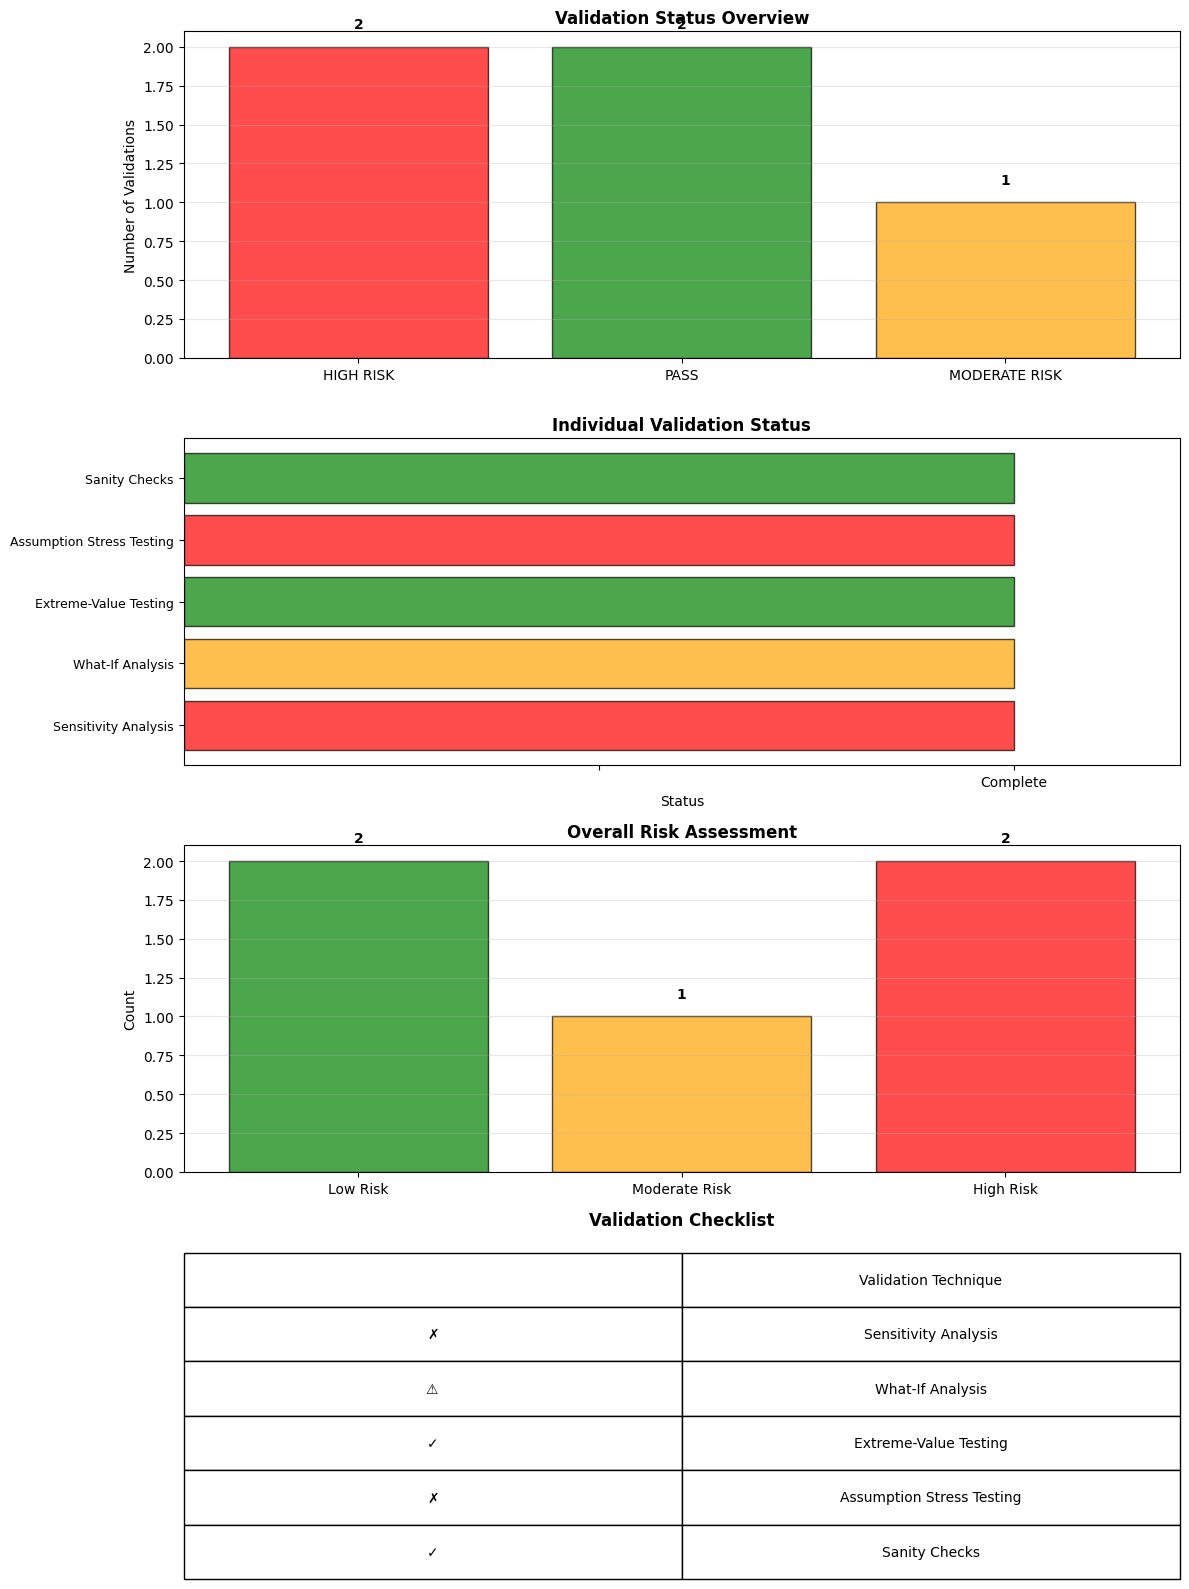

In [20]:
# Visualize - one plot per row for better readability
fig, axes = plt.subplots(4, 1, figsize=(12, 16))

# Plot 1: Validation Status Overview
ax1 = axes[0]
status_counts = validation_summary['Status'].value_counts()
colors_status = {'PASS': 'green', 'LOW RISK': 'lightgreen', 'MODERATE RISK': 'orange', 
                 'HIGH RISK': 'red', 'FAIL': 'darkred'}
status_colors = [colors_status.get(s, 'gray') for s in status_counts.index]
bars = ax1.bar(status_counts.index, status_counts.values, color=status_colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Number of Validations')
ax1.set_title('Validation Status Overview', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for bar, count in zip(bars, status_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             str(count), ha='center', va='bottom', fontweight='bold')

# Plot 2: Validation Techniques Status
ax2 = axes[1]
y_pos = np.arange(len(validation_summary))
colors_bar = [colors_status.get(s, 'gray') for s in validation_summary['Status']]
bars = ax2.barh(y_pos, [1]*len(validation_summary), color=colors_bar, alpha=0.7, edgecolor='black')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(validation_summary['Validation Technique'], fontsize=9)
ax2.set_xlabel('Status')
ax2.set_title('Individual Validation Status', fontweight='bold')
ax2.set_xlim(0, 1.2)
ax2.set_xticks([0.5, 1])
ax2.set_xticklabels(['', 'Complete'])

# Plot 3: Risk Assessment
ax3 = axes[2]
risk_levels = ['Low Risk', 'Moderate Risk', 'High Risk']
risk_counts = [
    sum([1 for s in validation_summary['Status'] if s == 'LOW RISK' or s == 'PASS']),
    sum([1 for s in validation_summary['Status'] if s == 'MODERATE RISK']),
    sum([1 for s in validation_summary['Status'] if s == 'HIGH RISK' or s == 'FAIL'])
]
colors_risk = ['green', 'orange', 'red']
bars = ax3.bar(risk_levels, risk_counts, color=colors_risk, alpha=0.7, edgecolor='black')
ax3.set_ylabel('Count')
ax3.set_title('Overall Risk Assessment', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
for bar, count in zip(bars, risk_counts):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             str(count), ha='center', va='bottom', fontweight='bold')

# Plot 4: Validation Checklist
ax4 = axes[3]
ax4.axis('off')
checklist_data = validation_summary[['Validation Technique', 'Status']].copy()
checklist_data['Check'] = ['✓' if 'PASS' in s or s == 'LOW RISK' else '⚠️' if 'MODERATE' in s else '✗' for s in checklist_data['Status']]
table = ax4.table(cellText=checklist_data[['Check', 'Validation Technique']].values,
                 colLabels=['', 'Validation Technique'],
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
ax4.set_title('Validation Checklist', fontweight='bold', pad=20)

plt.tight_layout()
plt.show()


## Summary: Comprehensive Validation Workflow

**What We Learned**:
- **Comprehensive validation** combines multiple validation techniques to thoroughly test model recommendations before deployment
- **No single technique catches everything** - each technique catches different types of problems, so you need all of them
- **Systematic validation prevents failures** - catching problems before deployment saves time, money, and reputation
- **Validation builds confidence** - you know the recommendation has been thoroughly tested across multiple dimensions

**The Five Validation Techniques**:
1. **Sensitivity Analysis**: Tests how recommendations change when inputs change - identifies how stable recommendations are
2. **What-If Analysis**: Explores multiple complete scenarios - shows how recommendations perform in different futures
3. **Extreme-Value Testing**: Tests model behavior at boundaries - finds the model's limits and valid operating range
4. **Assumption Stress Testing**: Systematically breaks assumptions - identifies which assumptions are critical
5. **Sanity Checks**: Applies business judgment - catches recommendations that are mathematically correct but practically absurd

**Key Insights**:
1. **Use all five techniques**: Each catches different problems - together they provide comprehensive coverage
2. **Systematic approach**: Follow a structured workflow to ensure nothing is missed
3. **Document everything**: Keep records of validation results for future reference and stakeholder communication
4. **Make informed decisions**: Use validation results to decide whether to implement, revise, or reject recommendations
5. **Validation is iterative**: If validations reveal problems, fix the model and validate again

**Practical Application**:
- Always perform comprehensive validation before implementing any model recommendation
- Follow a systematic workflow: sensitivity → what-if → extreme-value → stress-test → sanity checks
- Document validation results clearly for stakeholders
- Use validation results to make implementation decisions
- If validations reveal high risks, investigate and fix issues before implementing
- Don't skip validation steps - each technique catches different problems
- Comprehensive validation is standard practice - never deploy without it

**Remember**: Comprehensive validation is like quality control for recommendations. Just as you wouldn't sell a product without quality checks, you shouldn't implement a recommendation without comprehensive validation.
